In [1]:
%load_ext autoreload

In [266]:
%autoreload 2
from FEMOL import RectangleQuadMesh, FEM_Problem, PlaneStressResults
from FEMOL.utils import *
from FEMOL.materials import general_isotropic
import FEMOL.materials
import numpy as np
import time
import timeit
import scipy.linalg
import pyviennacl as p
import itertools
import numba as nb
import matplotlib.pyplot as plt
%config Completer.use_jedi = False
np.set_printoptions(linewidth=200)

def n_ele_dense_system_matrices(n):
    Lx, Ly = n, n
    mesh_args = [n]*4
    mesh = RectangleQuadMesh(*mesh_args)
    problem = FEM_Problem('displacement', 'plane', mesh)
    problem.define_materials(general_isotropic())
    problem.define_tensors(1)
    force_domains = create_domain([Lx], [[3*Ly/8, 5*Ly/8]]) # domain where the force is applied
    forces = [2, 0] # Force vector [Fx, Fy]
    problem.add_forces(forces, force_domains) # Add the force on the domains to the problem
    domain = create_domain([0] , [[0, Ly/4], [3*Ly/4, Ly]]) # create a domain object
    problem.add_fixed_domain(domain) # Fix the boundary
    problem.assemble('K', disable_vcl=True)

    return problem.K, problem.F

def n_element_plane_isotropic_problem(n):
    Lx, Ly = n, n
    mesh_args = [n]*4
    mesh = RectangleQuadMesh(*mesh_args)
    problem = FEM_Problem('displacement', 'plane', mesh)
    problem.define_materials(general_isotropic())
    problem.define_tensors(1)
    force_domains = create_domain([Lx], [[3*Ly/8, 5*Ly/8]]) # domain where the force is applied
    forces = [2, 0] # Force vector [Fx, Fy]
    problem.add_forces(forces, force_domains) # Add the force on the domains to the problem
    domain = create_domain([0] , [[0, Ly/4], [3*Ly/4, Ly]]) # create a domain object
    problem.add_fixed_domain(domain) # Fix the boundary
    problem.assemble('K')

    return problem


In [ ]:
problem_sizes = np.arange(60, 201, 20)

vcl_mat_time = []
vcl_solve_time = []
scipy_mat_time = []
scipy_solve_time = []

for size in problem_sizes:
    problem = n_element_problem(size)
    row = problem.K.row
    col = problem.K.col
    data = problem.K.data
    shape = problem.K.shape

    now = time.time()
    # fucking long
    K_vcl = p.CompressedMatrix((shape[0], shape[1], len(data)), dtype=p.float32)
    for i, j, v in zip(row, col, data):
        K_vcl[int(i),int(j)] = v
    F_vcl = p.Vector(problem.F.astype(np.float32))
    time_to_vcl_sparse = time.time() - now
    vcl_mat_time.append(time_to_vcl_sparse)

    now = time.time()
    U = K_vcl.solve(F_vcl, tag = p.cg_tag())
    fastest_solve_in_the_west = time.time() - now
    vcl_solve_time.append(fastest_solve_in_the_west)
    
    now = time.time()
    K_csr = problem.K.tocsr()
    mat_time = time.time() - now
    scipy_mat_time.append(mat_time)
    
    now = time.time()
    U = scipy.sparse.linalg.spsolve(K_csr, problem.F)
    scipy_GPU_solve = time.time() - now
    scipy_solve_time.append(scipy_GPU_solve)


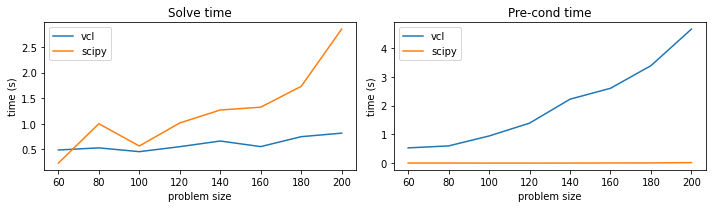

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax1.plot(problem_sizes, vcl_solve_time, label='vcl')
ax1.plot(problem_sizes, scipy_solve_time, label='scipy')
ax1.set_title('Solve time')
ax1.set_xlabel('problem size')
ax1.set_ylabel('time (s)')
ax1.legend()

ax2.plot(problem_sizes, vcl_mat_time, label='vcl')
ax2.plot(problem_sizes, scipy_mat_time, label='scipy')
ax2.set_title('Pre-cond time')
ax2.set_xlabel('problem size')
ax2.set_ylabel('time (s)')
ax2.legend()

plt.tight_layout()

In [25]:
fig.savefig('solve-precond', dpi=200)

In [243]:
n = 80
Lx, Ly = n, n
mesh_args = [n]*4
mesh = RectangleQuadMesh(*mesh_args)
problem = FEM_Problem('displacement', 'plane', mesh)
problem.define_materials(general_isotropic())
problem.define_tensors(1)

domain = create_domain([0] , [[0, Ly/4], [3*Ly/4, Ly]]) # create a domain object
problem.add_fixed_domain(domain) # Fix the boundary
problem.element_stiffness_matrix()

#problem.assemble_K()
#problem.fix_boundary()

In [244]:
rows, cols, data = problem.assemble_with_no_fix()

In [245]:
fix_rows = []
fix_cols = []
fix_diags = []
diag_indexes = []
Nd = 2

for domain, ddls in zip(problem.fixed_domains, problem.fixed_ddls):
    fixed_nodes = FEMOL.utils.domain_nodes(domain, problem.mesh)
    problem.fixed_nodes = np.append(problem.fixed_nodes, fixed_nodes)
    for node in fixed_nodes:
        for ddl in ddls:
            fixed_rows = rows == node * Nd + ddl
            fixed_cols = cols == node * Nd + ddl
            fixed_diag = np.logical_and(fixed_rows, fixed_cols)
            data[fixed_rows] = 0
            data[fixed_cols] = 0
            fix_rows.append(fixed_rows)
            fix_cols.append(fixed_cols)
            fix_diags.append(fixed_diag)
            diag_indexes.append(np.nonzero(fixed_diag))
    diag_indexes = np.hstack(diag_indexes).reshape(-1)
    _, index1 = np.unique(cols[diag_indexes], return_index=True)
    _, index2 = np.unique(rows[diag_indexes], return_index=True)
    if (index1 == index2).all():
        diag_indexes = diag_indexes[index1]
        data[diag_indexes] = 1